## Prerequisites
- Basic comfort with python, some linear algebra, some data science
- Download & Install Docker: https://docs.docker.com/install/
- Download ML4D_BroadE.zip from Google Drive: 

# Welcome to ML4D BroadE!

### Agenda
10:00-10:05: Intro Videos, Demos and Downloads 

10:05-10:30: Run docker jupyter server and open broad.ipynb and run first cell

10:30-10:45: Fundamental ML (linear and logistic regression, SGD, depth and interpretation)

10:45-11:00: Train models on well-studied datasets (MNIST, CIFAR10)

11:00-11:30: ML4CVD Abstractions: Tensorization, TensorMaps and the ModelFactory (& Julia Childs shoutout)

11:30-11:45: Coffee Break, Discussion and Data Exploration videos (groups coalesce: feature not bug)

11:45-11:55: Neurologist pep Talk from Chris Anderson

11:55-12:30: Defining TensorMaps on MNIST, Cifar and BiomedData sets.

12:15-12:30: Training models on the datasets

12:30-12:45: Saliency Maps  on BiomedData sets

12:45-12:59: Discussion and TensorMaps on your data


### Linear Regression
We explore machine learning on Bio medical data using Cloud computing, Python, Tensorflow, and the ML4CVD codebase.

We will start with linear regression.  Our model is a vector, one weight for each input feature, and a single bias weight.

\begin{equation}
y = xw + b
\end{equation}

For notational convenience absorb the bias term into the weight vector by adding a 1 to the input data matrix $X$

\begin{equation}
y = [\textbf{1}, X][b, \textbf{w}]^T
\end{equation}

#### The Dense Layer is Matrix (Tensor) Multiplication
![Matrix Multiplication](https://www.mathwarehouse.com/algebra/matrix/images/matrix-multiplication/how-to-multiply-2-matrices-demo.gif)

In [1]:
# Imports
import os
import sys
import pickle
import random
from typing import List, Dict, Callable
from collections import defaultdict, Counter

import csv
import gzip
import h5py
import shutil
import zipfile
import pydicom
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

from ml4cvd.defines import StorageType
from ml4cvd.arguments import parse_args, TMAPS, _get_tmap
from ml4cvd.TensorMap import TensorMap, Interpretation
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
from ml4cvd.models import train_model_from_generators, make_multimodal_multitask_model, _inspect_model
from ml4cvd.recipes import test_multimodal_multitask, train_multimodal_multitask, test_multimodal_scalar_tasks

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [2]:
# Constants
ZIP_FOLDER = '/home/sam/cq500/'
HD5_FOLDER = '/home/sam/ct_brain/'
MODEL_FOLDER = './models/'
EXCLUDE_SERIES = ['4cc', '_&_', '5mm', '3mm', 'helical']

In [17]:
def linear_regression():
    samples = 40
    real_weight = 2.0
    real_bias = 0.5
    x = np.linspace(-1, 1, samples)
    y = real_weight*x + real_bias + (np.random.randn(*x.shape) * 0.1)

    linear_model = Sequential()
    linear_model.add(Dense(1, input_dim=1))
    linear_model.compile(loss='mse', optimizer='sgd')
    linear_model.summary()
    linear_model.fit(x, y, batch_size=1, epochs=10)

    learned_slope = linear_model.get_weights()[0][0][0]
    learned_bias = linear_model.get_weights()[1][0]
    print('Learned slope:',  learned_slope, 'real slope:', real_weight, 'learned bias:', learned_bias, 'real bias:', real_bias)

    plt.plot(x, y)
    plt.plot([-1,1], [-learned_slope+learned_bias, learned_slope+learned_bias], 'r')
    plt.show()
    print('Linear Regression complete!')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 [==============================] - 1s 37ms/step - loss: 2.2751
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 1.2444
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6991
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 0.3982
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 0.2286
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 0.1338
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0798
Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0492
Epoch 9/10
40/40 [===

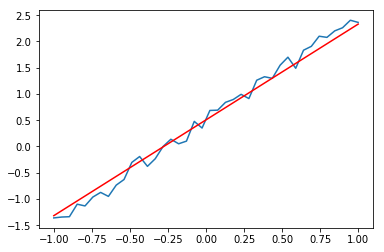

Linear Regression complete!


In [18]:
linear_regression()

## Now Logistic Regression:
We take the real-valued predictions from linear regression and squish them with a sigmoid.

\begin{equation}
\textbf{y} = \sigma(X\textbf{w} + b)
\end{equation}

where 
\begin{equation}
\sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}}
\end{equation}

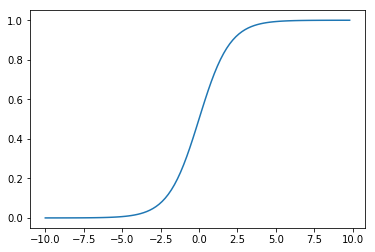

In [19]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(np.exp(item)/(1+np.exp(item)))
    return a

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

In [20]:
def logistic_regression(epochs = 1000, num_labels = 10):
    train, test, valid = load_data('mnist.pkl.gz')  
    
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    logistic_model = Sequential()
    logistic_model.add(Dense(num_labels, activation='softmax', input_dim=784, name='mnist_templates'))
    logistic_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    logistic_model.summary()
    
    templates = logistic_model.layers[0].get_weights()[0]
    plot_templates(templates, 0)
    print('weights shape:', templates.shape)

    for e in range(epochs):
        trainidx = random.sample(range(0, train[0].shape[0]), 8192)
        x_batch = train[0][trainidx,:]
        y_batch = train_y[trainidx]
        logistic_model.train_on_batch(x_batch, y_batch)
        if e % 100 == 0:
            plot_templates(logistic_model.layers[0].get_weights()[0], e)
            print('Logistic Model test set loss and accuracy:', logistic_model.evaluate(test[0], test_y), 'at epoch', e)


def plot_templates(templates, epoch):
    n = 10
    templates = templates.reshape((28,28,n))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        ax = plt.subplot(2, 5, i+1)		
        plt.imshow(templates[:, :, i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plot_name = "./regression_example/mnist_templates_"+str(epoch)+".png"
    if not os.path.exists(os.path.dirname(plot_name)):
        os.makedirs(os.path.dirname(plot_name))		
    plt.savefig(plot_name)


def make_one_hot(y, num_labels):
    ohy = np.zeros((len(y), num_labels))
    for i in range(0, len(y)):
        ohy[i][y[i]] = 1.0
    return ohy


def load_data(dataset):
    ''' Loads the dataset
    :param dataset: the path to the dataset (here MNIST)'''
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join("data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from urllib.request import urlretrieve
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        if not os.path.exists(os.path.dirname(dataset)):
            os.makedirs(os.path.dirname(dataset))	
        urlretrieve(origin, dataset)

    print('loading data...')
    f = gzip.open(dataset, 'rb')
    if sys.version_info[0] == 3:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    else:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    return train_set, valid_set, test_set

## Cross Entropy Loss:
Our favorite loss function for categorical data.
\begin{equation}
L(true, model) = -\sum_{x\in\mathcal{X}} true(x)\, \log model(x)
\end{equation}

Binary cross entropy with $N$ data points $x$ each with a binary label: 
\begin{equation}
true(x) \in \{0, 1\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1} true(x_i)\log(model(x_i)) + (1-true(x_i))log(1-model(x_i))
\end{equation}

This is the Kullback Leibler divergence between the true distribution and the predicted. 
This function emerges in many fields as diverse as probability, information theory, and physics.
What is the information difference between the truth and our model?  How much data do I lose by replacing the truth with the model's predictions. What is the temperature difference between my predictions and the truth?!

Categorical cross entropy with $K$ different classes or labels: 
\begin{equation}
true(x) \in \{0, 1, 2, ..., K\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1}\sum^K_{j=1} y_{ik}\log(q_k(x_i)))
\end{equation}

loading data...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_templates (Dense)      (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights shape: (784, 10)
10000/10000 [==============================] - 1s 115us/step
Logistic Model test set loss and accuracy: [2.40973745803833, 0.0957] at epoch 0
10000/10000 [==============================] - 0s 45us/step
Logistic Model test set loss and accuracy: [1.5805979988098144, 0.6627] at epoch 100
10000/10000 [==============================] - 0s 47us/step
Logistic Model test set loss and accuracy: [1.1958247117996217, 0.7783] at epoch 200
10000/10000 [==============================] - 0s 45us/step
Logistic Model test set loss and accuracy: [0.9874806694030762, 0.8159] at epoch 300
10000/10000 [===============

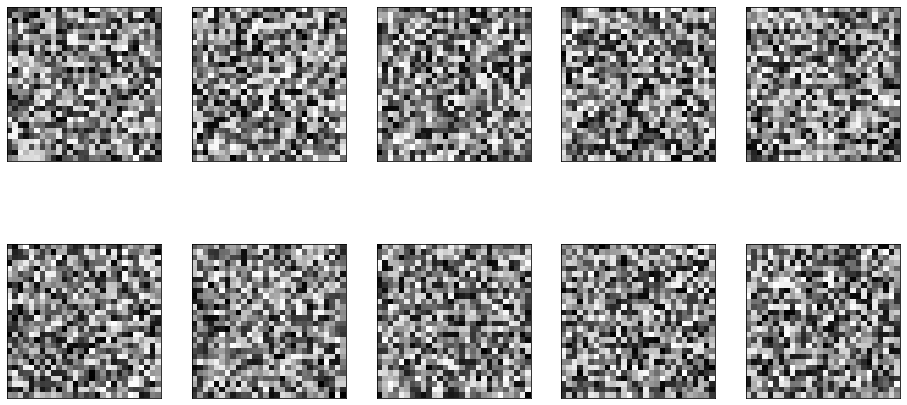

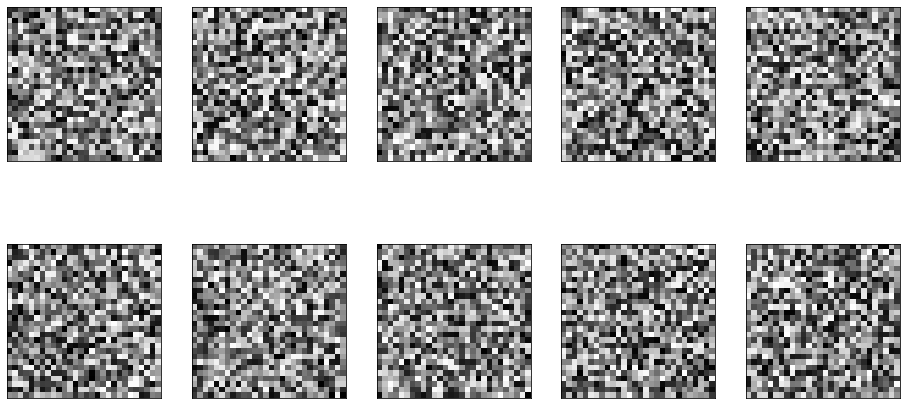

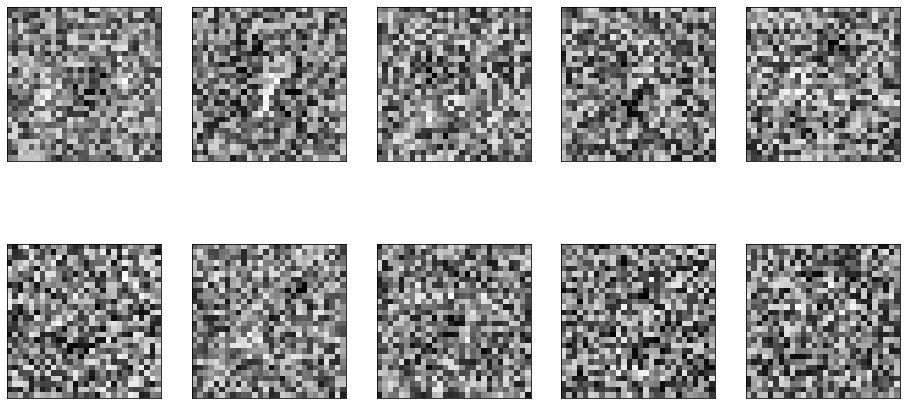

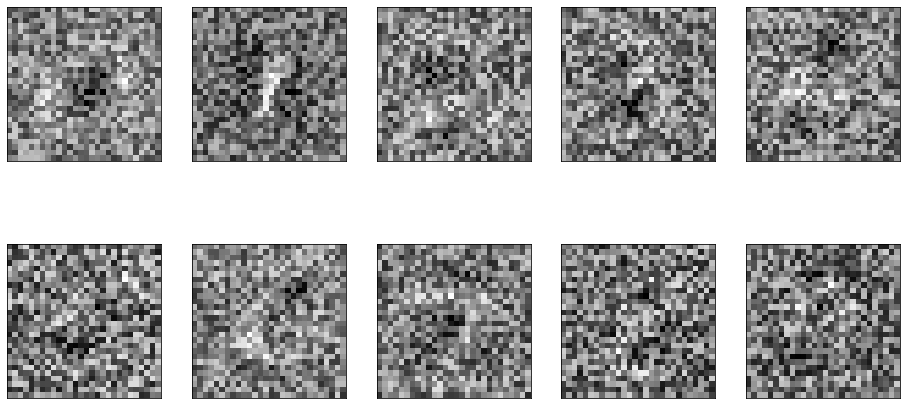

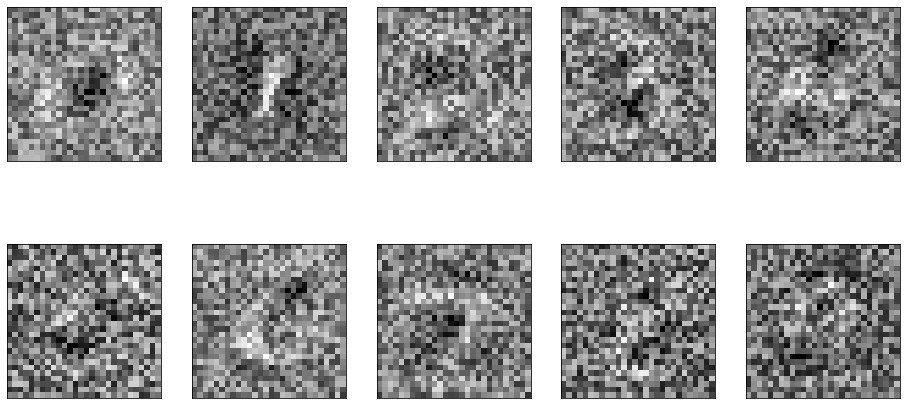

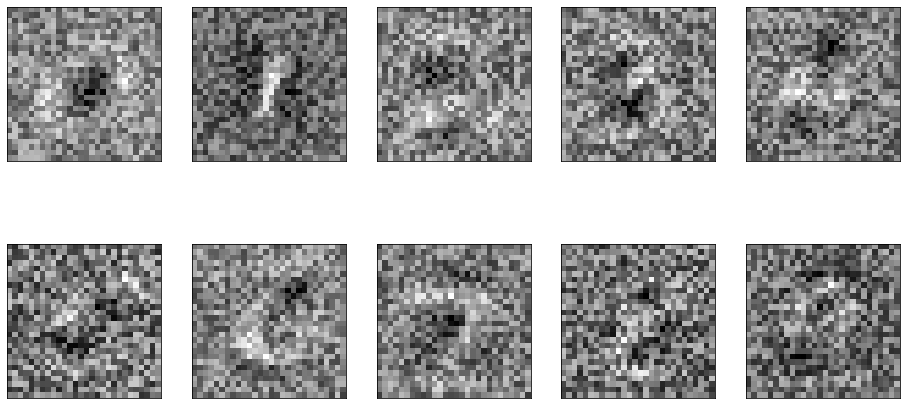

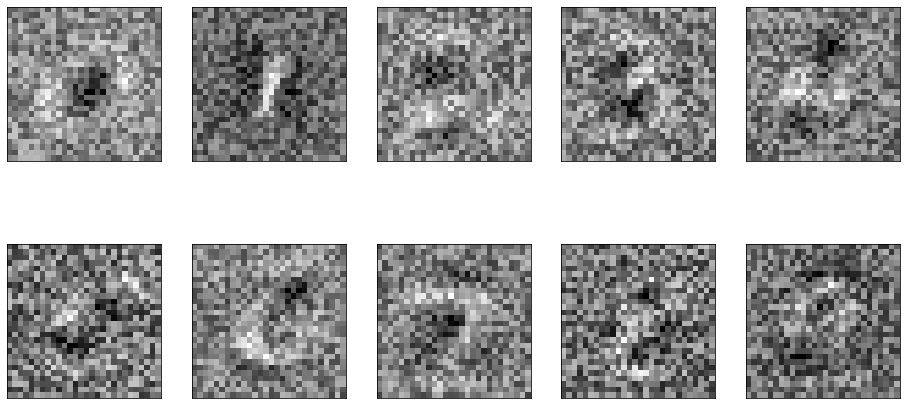

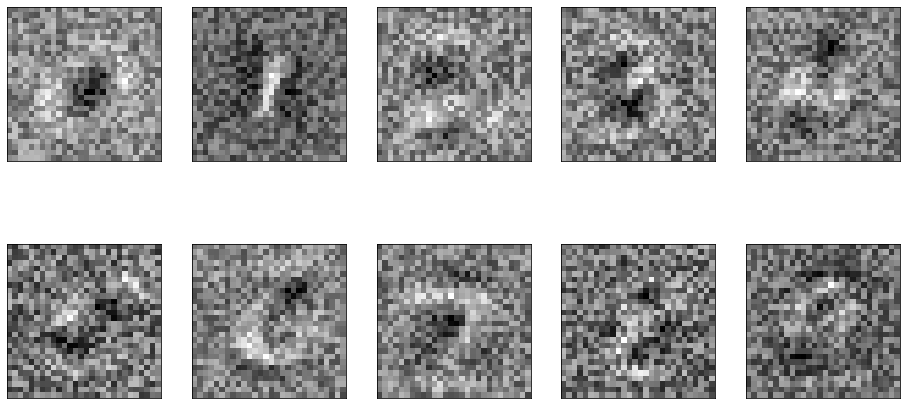

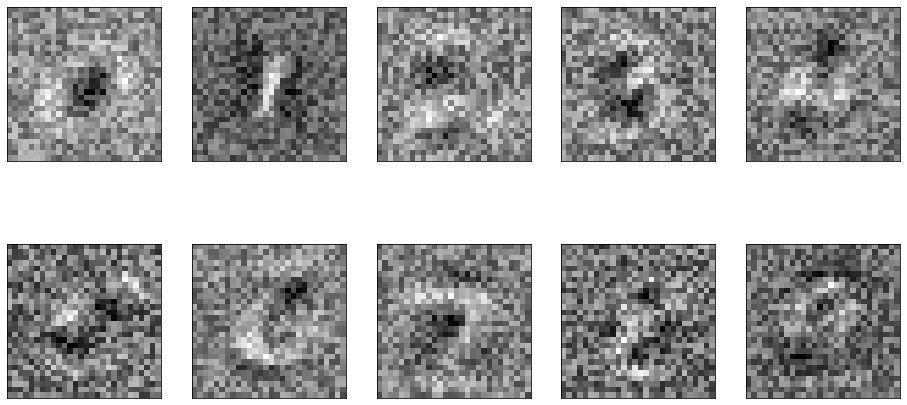

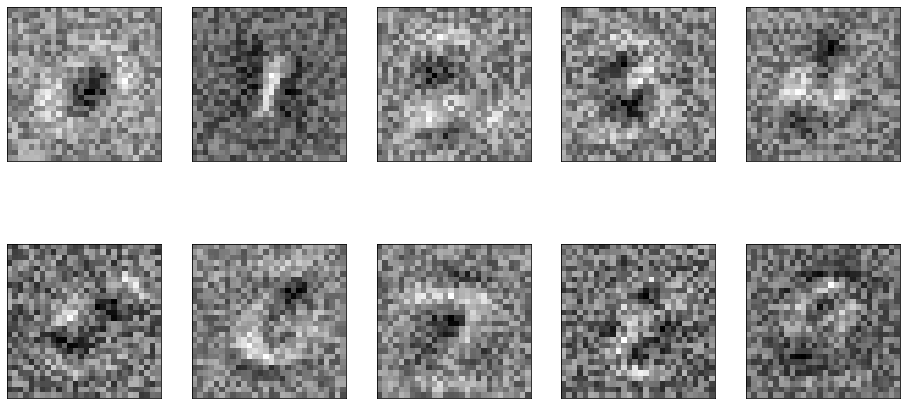

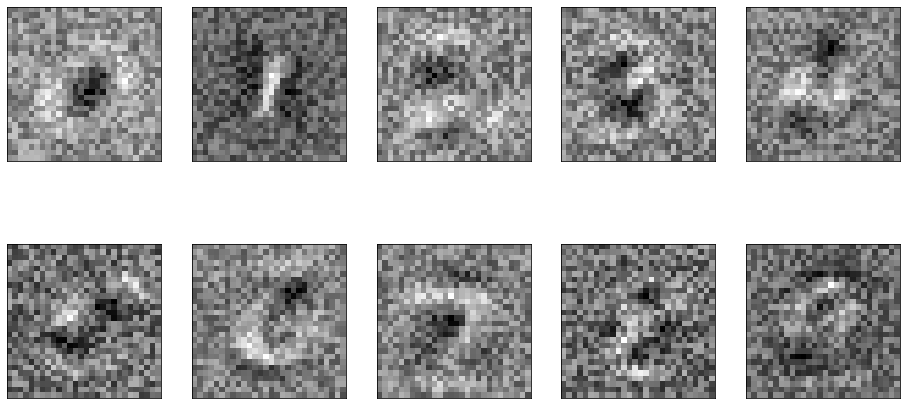

In [21]:
logistic_regression()

# Deep Models: "Hidden" Layers and The MultiLayerPerceptron

In [22]:
def multilayer_perceptron():
    train, test, valid = load_data('mnist.pkl.gz')

    num_labels = 10
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    mlp_model = Sequential()
    mlp_model.add(Dense(500, activation='relu', input_dim=784))
    mlp_model.add(Dense(num_labels, activation='softmax'))
    mlp_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    mlp_model.summary()
    mlp_model.fit(train[0], train_y, validation_data=(valid[0],valid_y), batch_size=32, epochs=3)
    print('Multilayer Perceptron trained. Test set loss and accuracy:', mlp_model.evaluate(test[0], test_y))

multilayer_perceptron()

loading data...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 7s 134us/step - loss: 0.6600 - acc: 0.8416 - val_loss: 0.3638 - val_acc: 0.9059
Epoch 2/3
50000/50000 [==============================] - 5s 99us/step - loss: 0.3465 - acc: 0.9047 - val_loss: 0.2974 - val_acc: 0.9179
Epoch 3/3
10000/10000 [==============================] - 0s 47us/step
Multilayer Perceptron trained. Test set loss and accuracy: [0.25638711591959, 0.9295]


# Convolutions Flip, Slide, Multiply, Add
Convolutions look for their kernel in a larger signal.

In convolution, you always and only find what you're looking with.

Convolution and cross correlation are deeply related:

\begin{equation}
f(t) \circledast g(t) \triangleq\ \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau. = \int_{-\infty}^\infty f(t-\tau) g(\tau)\, d\tau.
\end{equation}



![title](https://upload.wikimedia.org/wikipedia/commons/2/21/Comparison_convolution_correlation.svg)

loading data...
(50000, 784)
(50000, 28, 28, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
flatten_7 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                247824    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                170       
Total params: 266,810
Trainable params: 266,810
Non-trainable params: 0


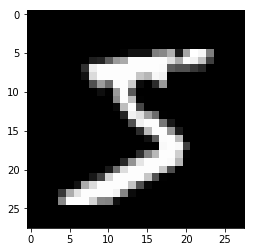

In [23]:
def convolutional_neural_network(filters=32, kernel_size=(3,3), padding='valid'):
    train, test, valid = load_data('mnist.pkl.gz')

    num_labels = 10
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    mnist_valid = valid[0].reshape((-1, 28, 28, 1))
    mnist_test = test[0].reshape((-1, 28, 28, 1))
    plt.imshow(mnist_images[0, ..., 0], cmap='gray')
    print(mnist_images.shape)
    cnn_model = Sequential()
    cnn_model.add(Conv2D(input_shape=(28, 28, 1), filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(16, activation='relu'))
    cnn_model.add(Dense(num_labels, activation='softmax'))
    cnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    cnn_model.summary()
    cnn_model.fit(mnist_images, train_y, validation_data=(mnist_valid, valid_y), batch_size=32, epochs=3)
    
    print('Convolutional Neural Network trained. Test set loss and accuracy:', cnn_model.evaluate(mnist_test, test_y))

convolutional_neural_network()

# Why (and When!) is Convolution Helpful?
- Decouples input size from model size
- Translationally Equivariant (Not Invariant), so we can find features wherever they might occur in the signal
- Local structure is often informative
- But not always! (eg Tabular data)

# ML4CVD Cosmology:  Tensors all the way down.


# ML4CVD Abstractions: Tensorization, the TensorMap, and the ModelFactory

## Tensorization
Tensorization is the process of gathering any number of input files and consolidating them into compressed HD5 files.  We tend to make one HD5 file per sample in the study.  The files contain the raw data and labels we will use to train models.  It tends to be efficient to separate tensor construction from model training.

In [ ]:
def parse_dicoms(dicom_folder, stats):
    dcm_file = ''
    my_stats = Counter()
    series = defaultdict(list)
    for root, _, files in os.walk(dicom_folder):
        for name in files:
            dcm_file = os.path.join(root, name)
            if not dcm_file.endswith('.dcm'):
                continue
            try:
                dcm = pydicom.read_file(dcm_file)
                my_stats[f'Shape {dcm.pixel_array.shape}'] += 1
                my_stats['count'] += 1
                my_stats[f'Series Number {dcm.SeriesNumber}'] += 1
                my_stats[f'Series Description {dcm.SeriesDescription}'] += 1
                my_stats[f'Pixel spacing{dcm.PixelSpacing}'] += 1
                series[dcm.SeriesDescription.lower().trim().replace(' ', '_').replace('/', '_')].append(dcm)
            except:
                my_stats['got an error'] += 1
                break
    print(f'\n At DICOM {dcm_file}')
    for k in my_stats:
        print(f'{k} has {my_stats[k]}') 
    
    try:
        tensors = {}
        for k in series:
            tensors[k] = np.zeros((512, 512, len(series[k])))
            for dcm in series[k]:
                tensors[k][..., dcm.InstanceNumber-1] = dcm.pixel_array
    except:
        my_stats['got a tensorization error'] += 1
            
    stats.update(my_stats)
    return tensors

In [ ]:
def tensorize_qure_ai_dicoms(zip_folder, dicom_folder, hd5_folder, delete_dicoms=True, limit_dicoms=-1):
    raw_data = {}
    stats = Counter()
    if not os.path.exists(dicom_folder):
        os.makedirs(dicom_folder)
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)    
    for z in os.listdir(zip_folder):
        if os.path.exists(os.path.join(hd5_folder, z.replace('.zip', '.hd5'))):
            continue
        with zipfile.ZipFile(zip_folder + z, "r") as zip_ref:
            zip_ref.extractall(dicom_folder)
            tensors = parse_dicoms(dicom_folder, stats)
            with h5py.File(os.path.join(hd5_folder, z.replace('.zip', '.hd5')), 'w') as hd5:
                for t in tensors:
                    hd5.create_dataset(t, data=tensors[t], compression='gzip')
        if delete_dicoms:
            shutil.rmtree(dicom_folder)
        if limit_dicoms > 0 and stats['count'] > limit_dicoms:
            break

    print('\n\n Full stats below:')
    for k in stats:
        print(f'{k} has {stats[k]}')

tensorize_qure_ai_dicoms(ZIP_FOLDER, './dicoms/', HD5_FOLDER, limit_dicoms=1000)



At DICOM ./dicoms/CQ500CT108 CQ500CT108/Unknown Study/CT 5mm/CT000031.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description 0.625mm has 1
Pixel spacing['0.496094', '0.496094'] has 2
got an error has 2
Series Number 2 has 1
Series Description 5mm has 1


At DICOM ./dicoms/CQ500CT207 CQ500CT207/Unknown Study/CT 5mm/CT000012.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description 0.625mm has 1
Pixel spacing['0.488281', '0.488281'] has 2
got an error has 2
Series Number 2 has 1
Series Description 5mm has 1


At DICOM ./dicoms/CQ500CT50 CQ500CT50/Unknown Study/CT 5mm/CT000031.dcm
got an error has 2


At DICOM ./dicoms/CQ500CT444 CQ500CT444/Unknown Study/CT 55mm Plain/CT000034.dcm
got an error has 2


At DICOM ./dicoms/CQ500CT317 CQ500CT317/Unknown Study/CT Plain/CT000031.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description PLAIN THIN has 1
Pixel spacing['0.443359', '0.443359'] has 2
got an error has 2
Series Numb



At DICOM ./dicoms/CQ500CT300 CQ500CT300/Unknown Study/CT 55mm Plain/CT000031.dcm
got an error has 2


At DICOM ./dicoms/CQ500CT481 CQ500CT481/Unknown Study/CT Plain/CT000012.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description PLAIN THIN has 1
Pixel spacing['0.447266', '0.447266'] has 2
got an error has 2
Series Number 2 has 1
Series Description Plain has 1


At DICOM ./dicoms/CQ500CT45 CQ500CT45/Unknown Study/CT PRE CONTRAST BONE/CT000012.dcm
Shape (512, 512) has 3
count has 3
Series Number 4 has 1
Series Description PRE CONTRAST 5MM STD has 1
Pixel spacing['0.410156', '0.410156'] has 3
got an error has 3
Series Number 2 has 1
Series Description PRE CONTRAST THIN has 1
Series Number 3 has 1
Series Description  PRE CONTRAST BONE has 1


At DICOM ./dicoms/CQ500CT51 CQ500CT51/Unknown Study/CT Plain/CT000012.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description PLAIN THIN has 1
Pixel spacing['0.460938', '0.460938'] has 2
got an error 



At DICOM ./dicoms/CQ500CT174 CQ500CT174/Unknown Study/CT 5mm/CT000031.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description 0.625mm has 1
Pixel spacing['0.503906', '0.503906'] has 2
got an error has 2
Series Number 2 has 1
Series Description 5mm has 1


At DICOM ./dicoms/CQ500CT349 CQ500CT349/Unknown Study/CT PRE CONTRAST BONE/CT000034.dcm
got an error has 3


At DICOM ./dicoms/CQ500CT362 CQ500CT362/Unknown Study/CT 55mm Plain/CT000031.dcm
got an error has 2


At DICOM ./dicoms/CQ500CT145 CQ500CT145/Unknown Study/CT Plain/CT000012.dcm
Shape (512, 512) has 3
count has 3
Series Number 4 has 1
Series Description BONE has 1
Pixel spacing['0.431641', '0.431641'] has 3
got an error has 3
Series Number 3 has 1
Series Description PLAIN THIN has 1
Series Number 2 has 1
Series Description Plain has 1


At DICOM ./dicoms/CQ500CT34 CQ500CT34/Unknown Study/CT PRE CONTRAST BONE/CT000031.dcm
got an error has 3


At DICOM ./dicoms/CQ500CT258 CQ500CT258/Unknown Study/CT Plai



At DICOM ./dicoms/CQ500CT302 CQ500CT302/Unknown Study/CT 55mm Plain/CT000031.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description Thin Plain has 1
Pixel spacing['0.460938', '0.460938'] has 2
got an error has 2
Series Number 2 has 1
Series Description 5/5mm Plain has 1


At DICOM ./dicoms/CQ500CT212 CQ500CT212/Unknown Study/CT 55mm Plain/CT000034.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description Thin Plain has 1
Pixel spacing['0.498047', '0.498047'] has 2
got an error has 2
Series Number 2 has 1
Series Description 5/5mm Plain has 1


At DICOM ./dicoms/CQ500CT355 CQ500CT355/Unknown Study/CT PRE CONTRAST BONE/CT000034.dcm
Shape (512, 512) has 6
count has 6
Series Number 301 has 1
Series Description THIN BONE has 1
Pixel spacing['0.539062', '0.539062'] has 4
got an error has 6
Series Number 302 has 1
Series Description THIN BONE PNS 5/5 has 1
Pixel spacing['0.299801', '0.299801'] has 2
Series Number 4 has 1
Series Description PRE C



At DICOM ./dicoms/CQ500CT22 CQ500CT22/Unknown Study/CT Plain/CT000012.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description PLAIN THIN has 1
Pixel spacing['0.445312', '0.445312'] has 2
got an error has 2
Series Number 2 has 1
Series Description Plain has 1


At DICOM ./dicoms/CQ500CT472 CQ500CT472/Unknown Study/CT PRE CONTRAST BONE/CT000012.dcm
Shape (512, 512) has 3
count has 3
Series Number 4 has 1
Series Description PRE CONTRAST 5MM STD has 1
Pixel spacing['0.488281', '0.488281'] has 3
got an error has 3
Series Number 2 has 1
Series Description PRE CONTRAST THIN has 1
Series Number 3 has 1
Series Description  PRE CONTRAST BONE has 1


At DICOM ./dicoms/CQ500CT415 CQ500CT415/Unknown Study/CT 2.55mm/CT000031.dcm
Shape (512, 512) has 1
count has 1
Series Number 2 has 1
Series Description 2.5/5mm has 1
Pixel spacing['0.580078', '0.580078'] has 1
got an error has 1


At DICOM ./dicoms/CQ500CT48 CQ500CT48/Unknown Study/CT 4cc sec 150cc D3D on/CT000167.dcm
Shape



At DICOM ./dicoms/CQ500CT89 CQ500CT89/Unknown Study/CT PRE CONTRAST BONE/CT000012.dcm
got an error has 3


At DICOM ./dicoms/CQ500CT196 CQ500CT196/Unknown Study/CT 5mm/CT000031.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description 0.625mm has 1
Pixel spacing['0.488281', '0.488281'] has 2
got an error has 2
Series Number 2 has 1
Series Description 5mm has 1


At DICOM ./dicoms/CQ500CT103 CQ500CT103/Unknown Study/CT 55mm Plain/CT000031.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description Thin Plain has 1
Pixel spacing['0.429688', '0.429688'] has 2
got an error has 2
Series Number 2 has 1
Series Description 5/5mm Plain has 1


At DICOM ./dicoms/CQ500CT275 CQ500CT275/Unknown Study/CT PRE CONTRAST BONE/CT000012.dcm
Shape (512, 512) has 3
count has 3
Series Number 4 has 1
Series Description PRE CONTRAST 5MM STD has 1
Pixel spacing['0.488281', '0.488281'] has 3
got an error has 3
Series Number 2 has 1
Series Description PRE CONTRAST THIN 



At DICOM ./dicoms/CQ500CT123 CQ500CT123/Unknown Study/CT Plain/CT000012.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description PLAIN THIN has 1
Pixel spacing['0.414062', '0.414062'] has 2
got an error has 2
Series Number 2 has 1
Series Description Plain has 1


At DICOM ./dicoms/CQ500CT70 CQ500CT70/Unknown Study/CT Plain/CT000034.dcm
Shape (512, 512) has 2
count has 2
Series Number 3 has 1
Series Description PLAIN THIN has 1
Pixel spacing['0.488281', '0.488281'] has 2
got an error has 2
Series Number 2 has 1
Series Description Plain has 1


At DICOM ./dicoms/CQ500CT73 CQ500CT73/Unknown Study/CT C THIN/CT000167.dcm
Shape (512, 512) has 6
count has 6
Series Number 6 has 1
Series Description DE has 1
Pixel spacing['0.443359', '0.443359'] has 6
got an error has 6
Series Number 7 has 1
Series Description DE THIN has 1
Series Number 4 has 1
Series Description +C has 1
Series Number 3 has 1
Series Description PLAIN THIN has 1
Series Number 2 has 1
Series Description

In [ ]:
!head -5 /home/sam/reads.csv 

In [ ]:
def tensorize_qure_ai_reads(read_file, hd5_folder):
    stats = Counter()
    with open(read_file, 'r') as my_csv:
        lol = list(csv.reader(my_csv, delimiter=','))
        header = [h.replace(':', '_').lower() for h in lol[0]]
        print(f'header is {header}')
        for row in lol[1:]:
            try:
                with h5py.File(f'{hd5_folder}{row[0]}.hd5', 'a') as hd5:
                    for i, value in enumerate(row[2:]):
                        hd5.create_dataset(header[i+2], data=[int(value)])
            except:
                print(f'Could not open {row[0]}')
    for k in stats:
        print(f'{k} has {stats[k]}')

## TensorMaps
The critical data structure in the ML4CVD codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.  TensorMaps guarantee a shape, a way to consturct tensors of that shape from the HD5 files created during tensorization and a meaning to the values in the tensor that the TensorMap yields.

In [13]:
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28))
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28, 1))

mnist_channel_map = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'zero': 4, 'zero': 5, 
                     'six': 6, 'seven': 9, 'eight': 8, 'nine': 9}

mnist_class = TensorMap('mnist_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=mnist_channel_map)

In [14]:
cifar_image = TensorMap('cifar_image', Interpretation.CONTINUOUS, shape=(32, 32, 3))

cifar_channel_map = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 
                     'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

cifar_class = TensorMap('cifar_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=cifar_channel_map)

In [39]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
        with h5py.File(path, 'r') as hd5:
            for tmap in tmaps:
                try:
                    result_dict[tmap] = tmap.normalize_and_validate(tmap.tensor_from_file(tmap, hd5))
                except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                    continue
    return result_dict

In [16]:
def plot_array_3d(a):
    slice_axis = -1
    sides = int(np.ceil(np.sqrt(a.shape[slice_axis])))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    print(a.shape)
    vmin = np.min(a)
    vmax = np.max(a)
    for i in range(a.shape[slice_axis]):
        axes[i//sides, i%sides].imshow(a[..., i], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i//sides, i%sides].set_yticklabels([])
        axes[i//sides, i%sides].set_xticklabels([])

In [4]:

def middle_slices(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):    
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] > 50:
            if any(exclude in k for exclude in EXCLUDE_SERIES):
                continue

            middle_indexes = np.array(list(hd5[k].shape)) // 2
            start_indexes = [mi - (tm.shape[i] // 2) for i, mi in enumerate(middle_indexes)]
            stop_indexes = [mi + (tm.shape[i] // 2) + tm.shape[i]%2 for i, mi in enumerate(middle_indexes)]
            middle = hd5[k][start_indexes[0]:stop_indexes[0], start_indexes[1]:stop_indexes[1], start_indexes[2]:stop_indexes[2]]
            slices = np.array(middle, dtype=np.float32)
            if np.mean(slices) == 0:
                continue
            return slices
    raise ValueError('No CT slices in HD5')
TMAPS['middle_slices_2'] = TensorMap('middle_slices_2', shape=(256, 256, 2), tensor_from_file=middle_slices, normalization={'zero_mean_std1': True})

   
TMAPS['middle_slices_4'] = TensorMap('middle_slices_4', shape=(372, 292, 4), tensor_from_file=middle_slices, normalization={'zero_mean_std1': True})
TMAPS['middle_slices_16'] = TensorMap('middle_slices_16', shape=(372, 292, 16), tensor_from_file=middle_slices, normalization={'zero_mean_std1': True})
TMAPS['middle_slices_25'] = TensorMap('middle_slices_25', shape=(512, 512, 25), tensor_from_file=middle_slices, normalization={'zero_mean_std1': True})
TMAPS['middle_slices_64'] = TensorMap('middle_slices_64', shape=(512, 512, 64), tensor_from_file=middle_slices, normalization={'zero_mean_std1': True})


k izzz: thin_plain
k thin_plain m: 6604.989533848233 std: 9396.305596191147
at: CQ500-CT-200 middle_slices_4 has (372, 292, 4)
(372, 292, 4)

k izzz: plain_thin
k plain_thin m: 3925.3626736166025 std: 7203.344409260266
at: CQ500-CT-201 middle_slices_4 has (372, 292, 4)
(372, 292, 4)

k izzz: plain_thin
k plain_thin m: 7017.561974003911 std: 12367.87428759055
at: CQ500-CT-202 middle_slices_4 has (372, 292, 4)
(372, 292, 4)

k izzz: plain_thin
k plain_thin m: 416.4475298384889 std: 544.4367303521587
at: CQ500-CT-203 middle_slices_4 has (372, 292, 4)
(372, 292, 4)

k izzz: plain_thin
k plain_thin m: 8.45412081082662 std: 1179.6019914457245
at: CQ500-CT-204 middle_slices_4 has (372, 292, 4)
(372, 292, 4)


k izzz: soft_thin
k soft_thin m: 11198.927214873002 std: 10082.667659072775
at: CQ500-CT-206 middle_slices_4 has (372, 292, 4)
(372, 292, 4)




k izzz: plain_thin
k plain_thin m: 295.8770004624587 std: 513.4486255710688
at: CQ500-CT-210 middle_slices_4 has (372, 292, 4)
(372, 292, 4)



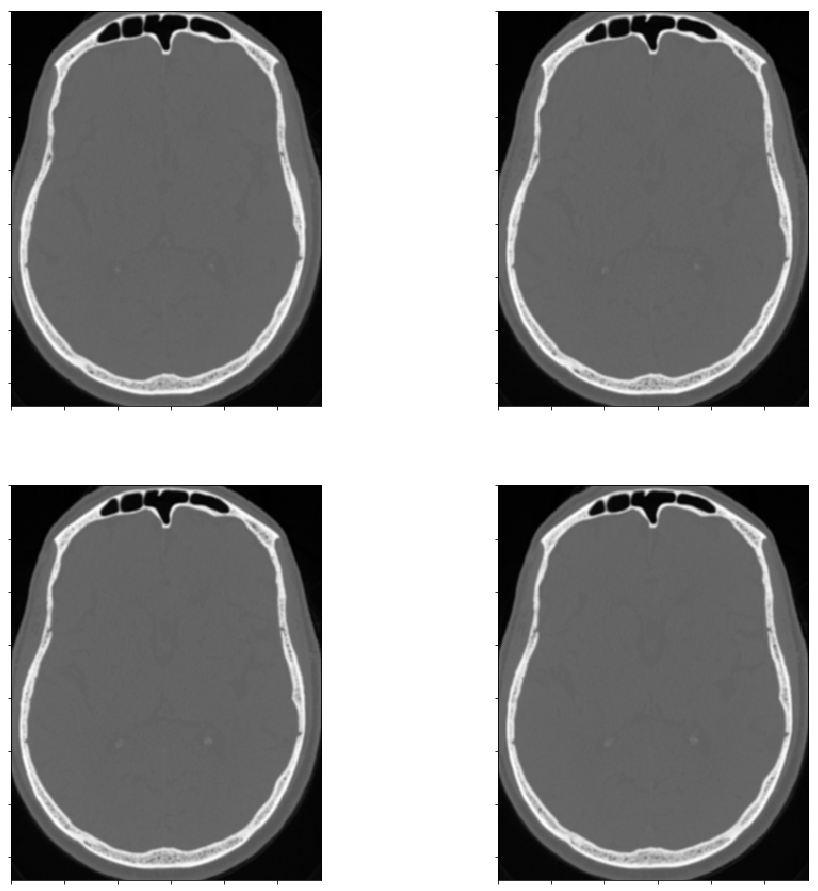

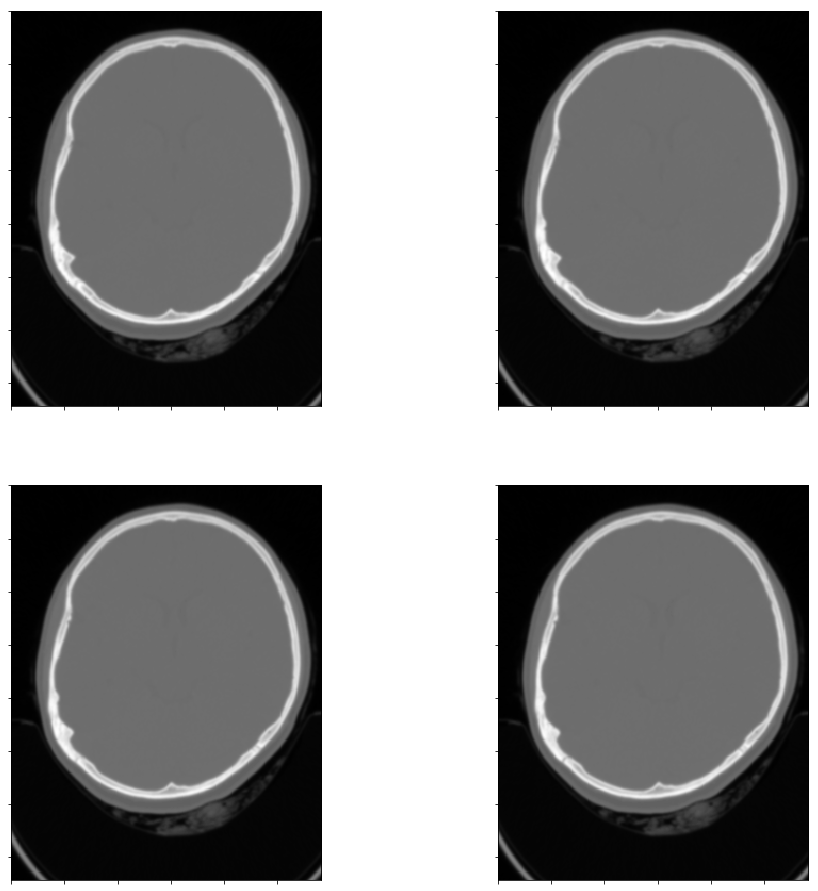

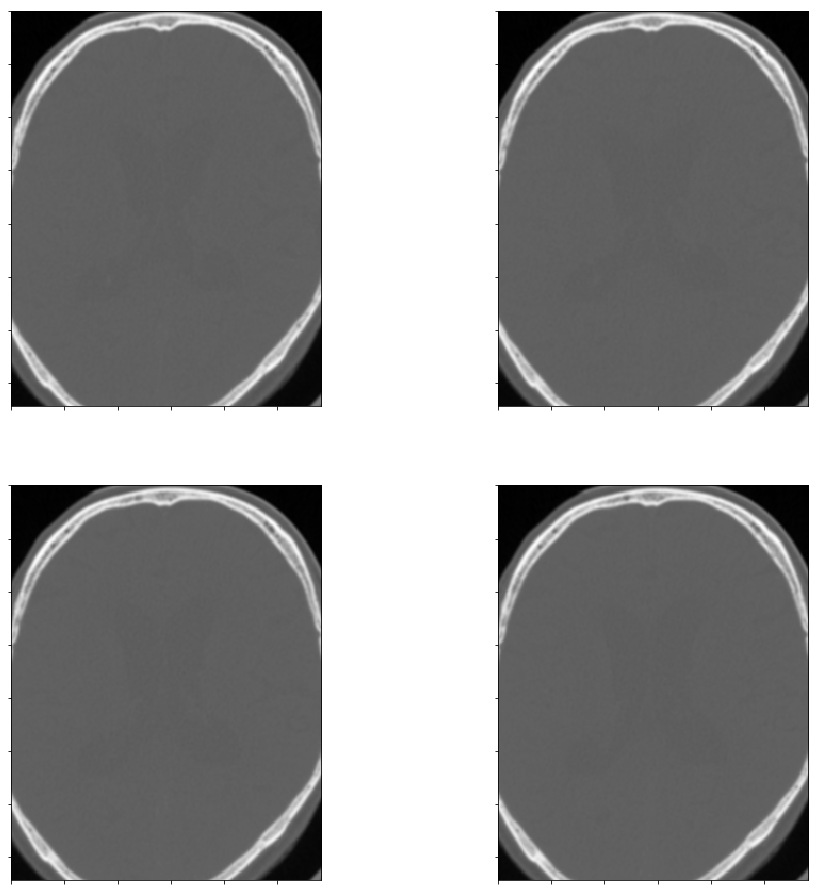

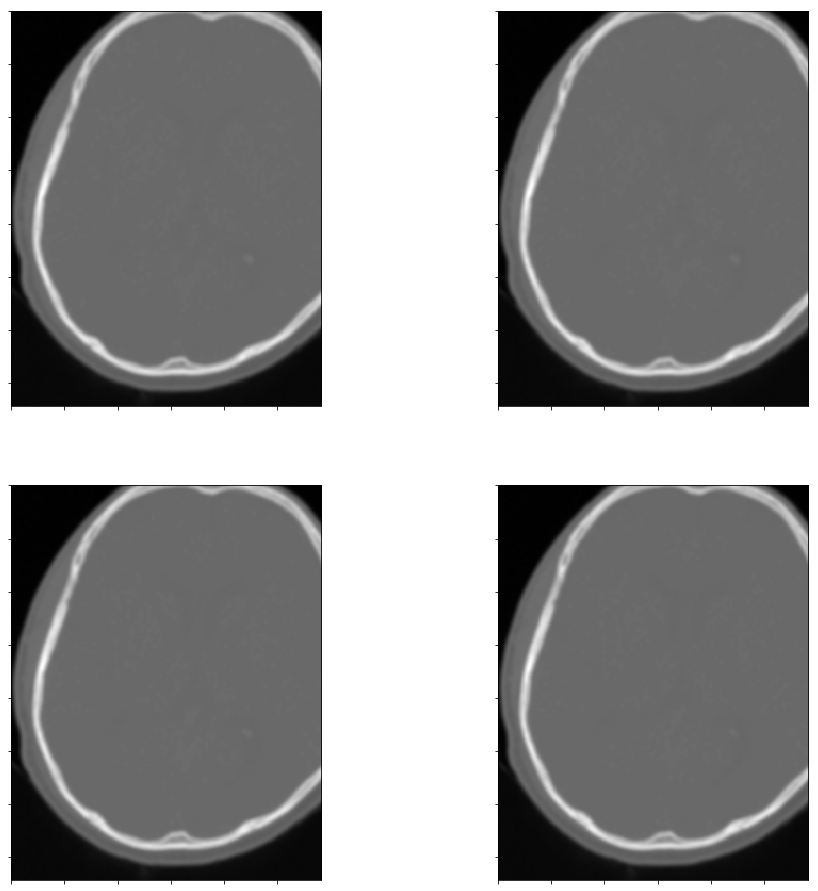

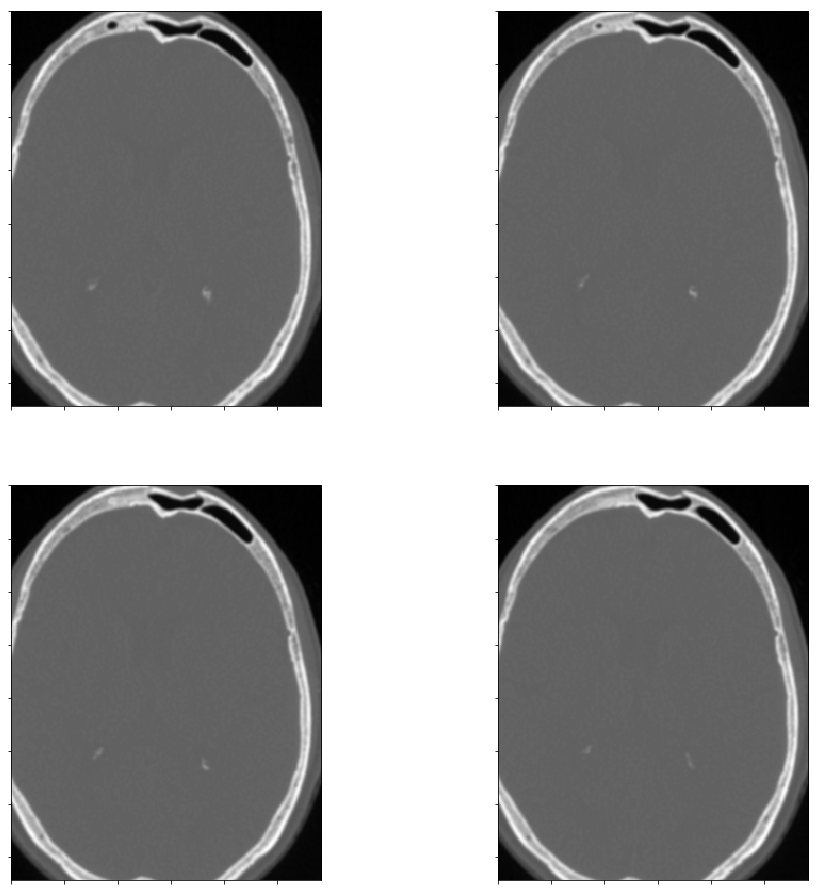

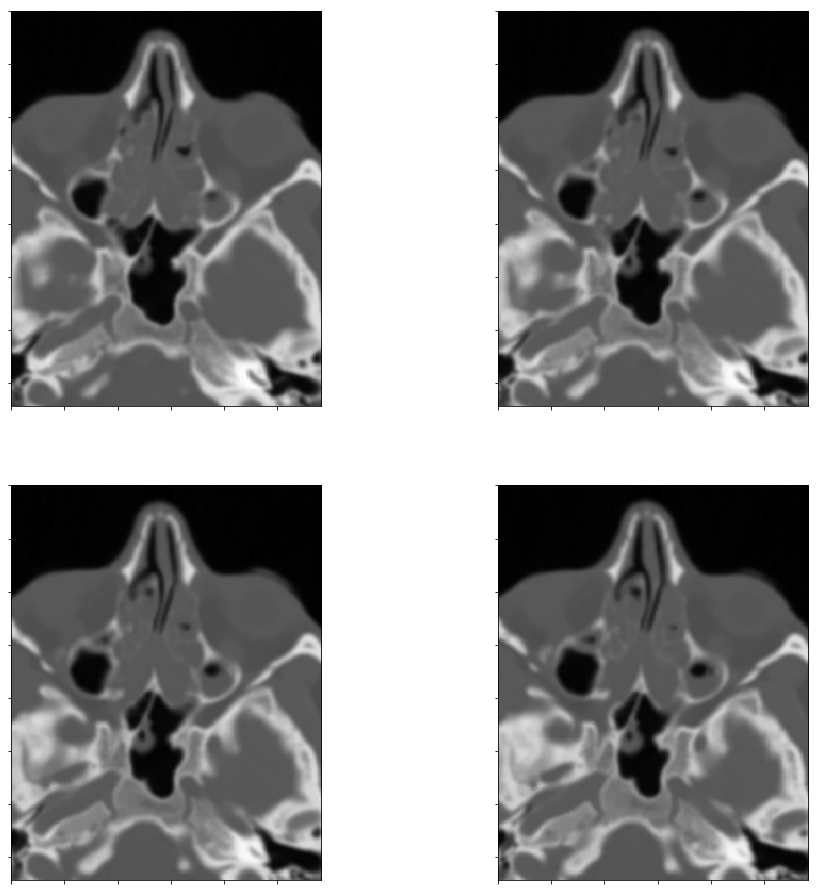

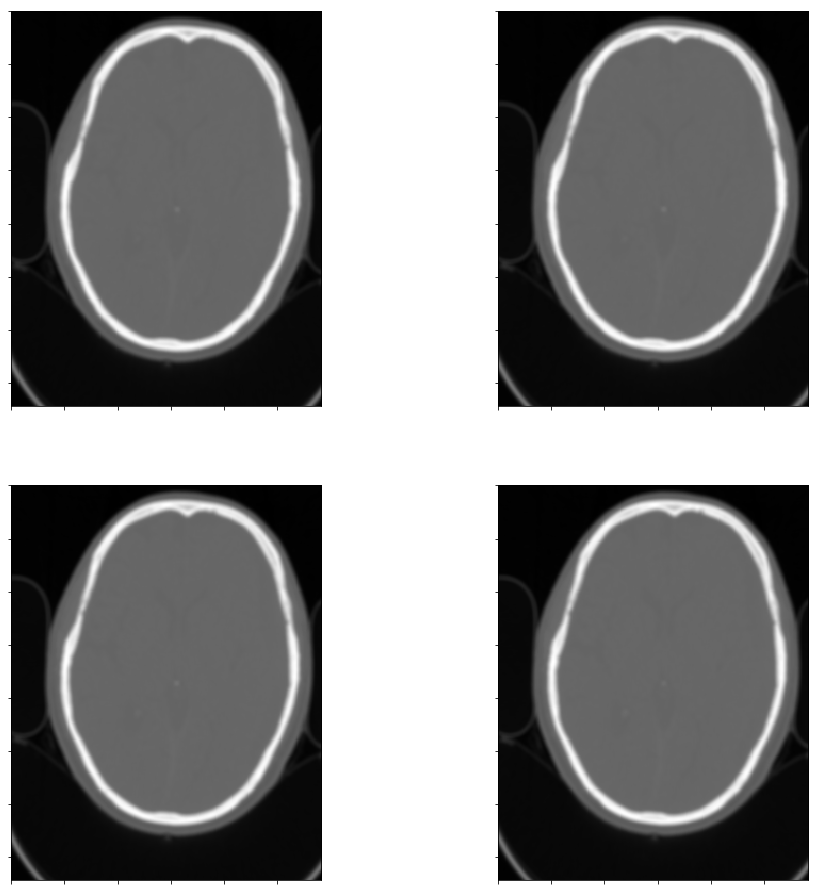

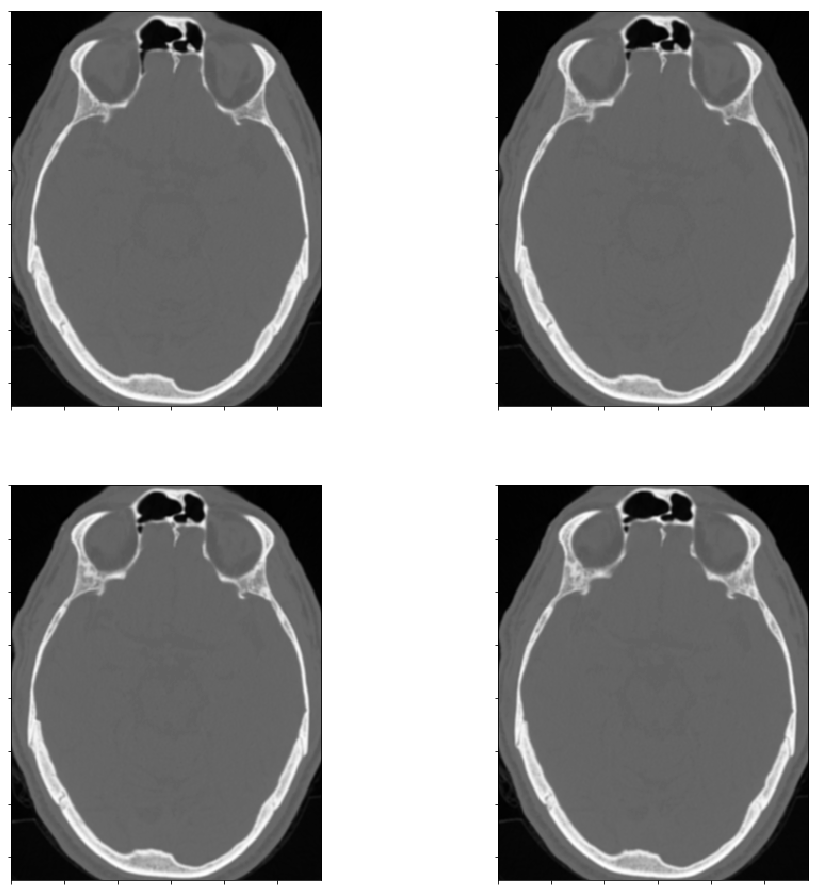

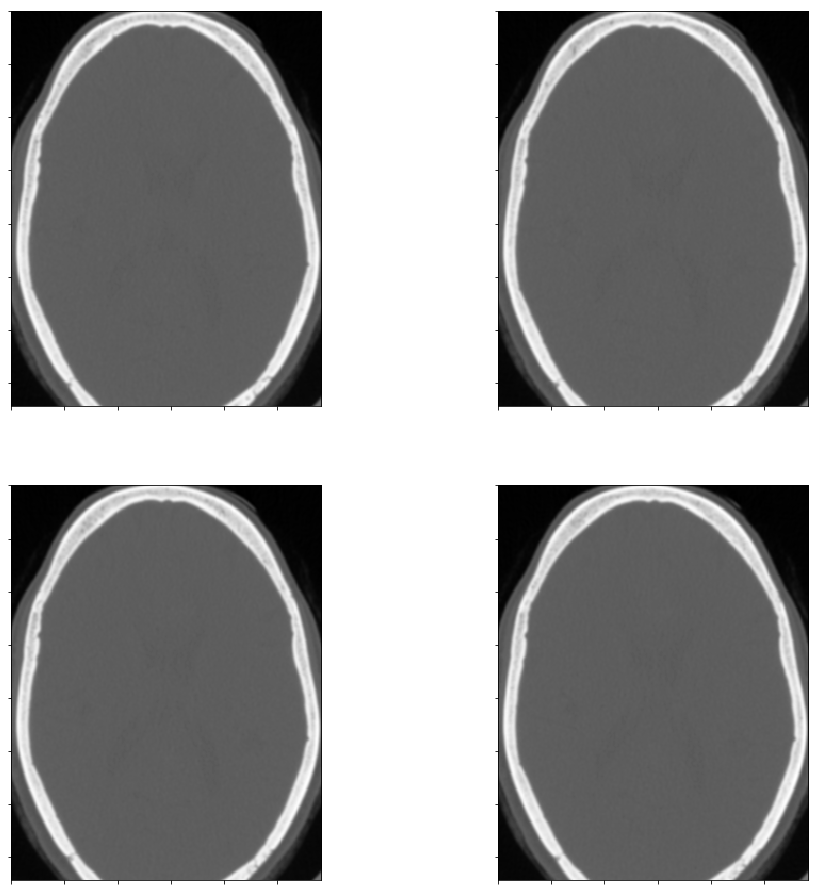

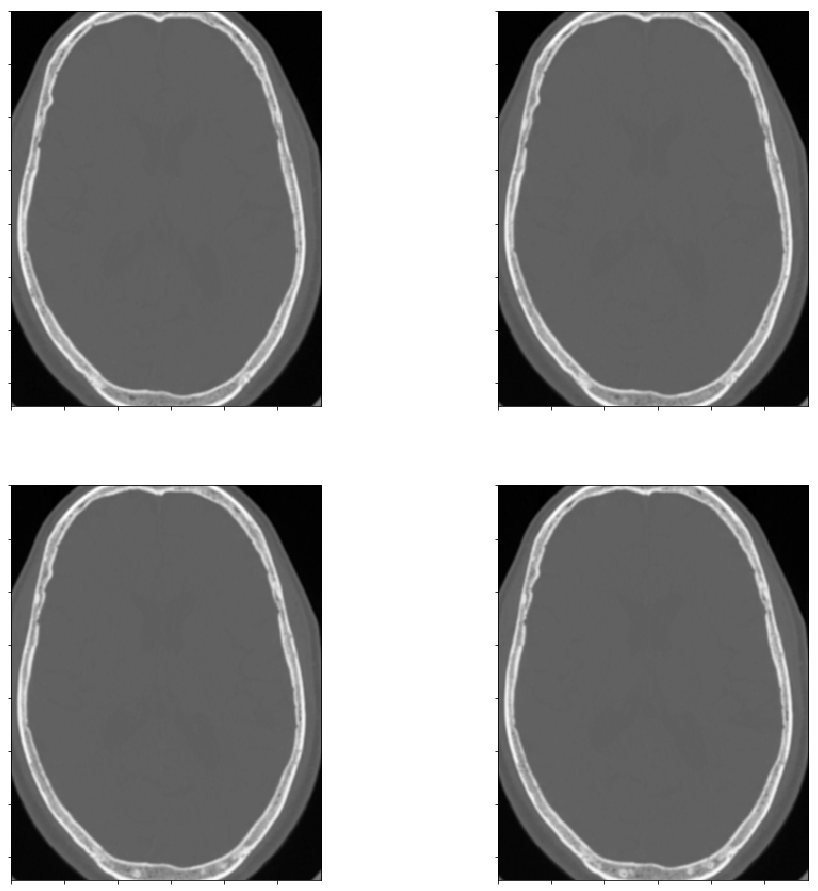

In [151]:
for i in range(200,218):
    print()
    t = tmaps_by_sample_id(HD5_FOLDER, f'CQ500-CT-{i}', [_get_tmap('middle_slices_4')])
    for k in t:
        print(f'at: CQ500-CT-{i} {k.name} has {t[k].shape}')
        plot_array_3d(t[k])

In [198]:
def slice_from_hd5(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] < 50:
            random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
            random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
            random_slices = np.clip(random_slices, 3000, 10000)
            return random_slices
    raise ValueError('No CT slices in HD5')
   
TMAPS['slice_map'] = TensorMap('slice_map', shape=(512, 512, 1), tensor_from_file=slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map5'] = TensorMap('slice_map5', shape=(512, 512, 5), tensor_from_file=slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map25'] = TensorMap('slice_map25', shape=(512, 512, 25), tensor_from_file=slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})

slice_map25 has (512, 512, 25)
(512, 512, 25)


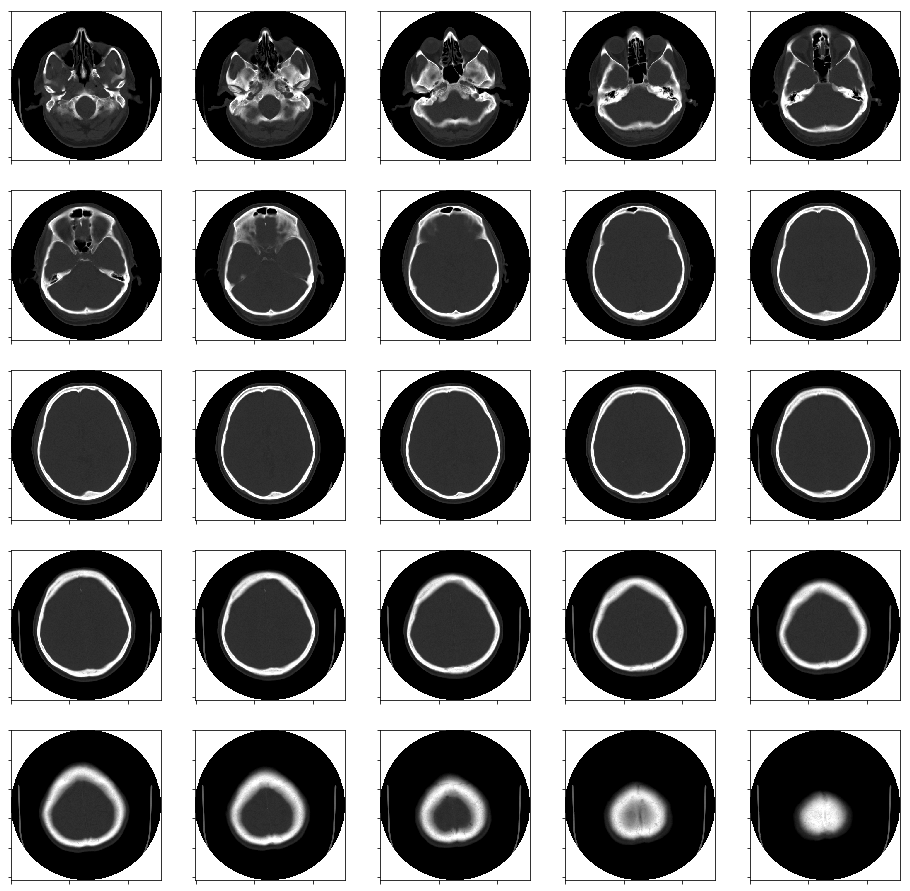

In [7]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-222', [ _get_tmap('slice_map25')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [208]:
def middle_slices(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] < 50:
            middle_index = hd5[k].shape[-1] // 2
            start_index = middle_index - (tm.shape[-1] // 2)
            stop_index = middle_index + (tm.shape[-1] // 2) + tm.shape[-1]%2
            slices = np.array(hd5[k][..., start_index : stop_index], dtype=np.float32)
            slices = np.clip(slices, 3000, 10000)
            return slices
    raise ValueError('No CT slices in HD5')
   
TMAPS['middle_slices_5'] = TensorMap('middle_slices_5', shape=(512, 512, 5), tensor_from_file=middle_slices, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['middle_slices_16'] = TensorMap('middle_slices_16', shape=(512, 512, 16), tensor_from_file=middle_slices, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['middle_slices_25'] = TensorMap('middle_slices_25', shape=(512, 512, 25), tensor_from_file=middle_slices, cacheable=False, normalization={'zero_mean_std1': True})

slice_map25 has (512, 512, 25)
(512, 512, 25)


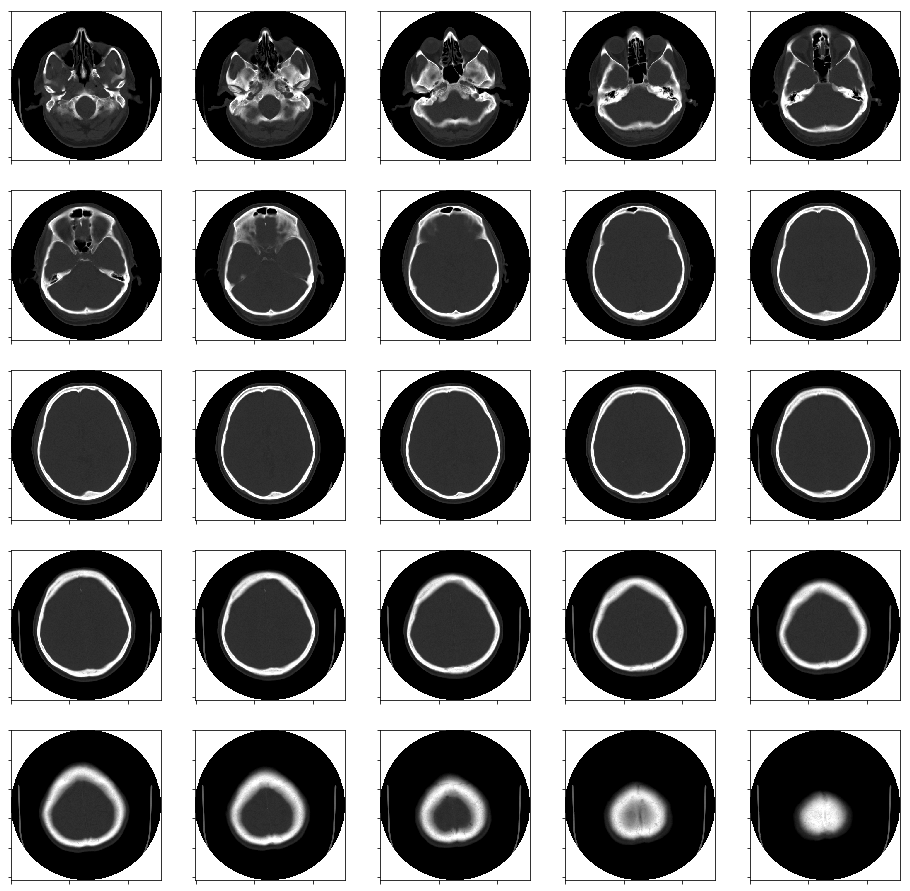

In [7]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-222', [ _get_tmap('slice_map25')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [191]:

def crop_voxels(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3:
            if any(exclude in k for exclude in EXCLUDE_SERIESexclude_series):
                continue
            if hd5[k].shape[-1] < 50:
                   continue
            x_index = np.random.randint(hd5[k].shape[0]-tm.shape[0])
            y_index = np.random.randint(hd5[k].shape[1]-tm.shape[1])
            middle_index = hd5[k].shape[-1] // 2
            start_index = middle_index - (tm.shape[-1] // 2)
            stop_index = middle_index + (tm.shape[-1] // 2) + tm.shape[-1]%2
            z_index = np.random.randint(hd5[k].shape[2]-tm.shape[2])
            random_slices = np.array(hd5[k][x_index:x_index+tm.shape[0], y_index:y_index+tm.shape[1], start_index:stop_index], dtype=np.float32)
            return random_slices
    raise ValueError('No CT slices in HD5')

    
TMAPS['crop_thin_64'] = TensorMap('crop_thin_64', shape=(64, 64, 64), tensor_from_file=crop_voxels, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['crop_thin_316'] = TensorMap('crop_thin_316', shape=(316, 192, 64), tensor_from_file=crop_voxels, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['crop_thin_372'] = TensorMap('crop_thin_372', shape=(372, 292, 121), tensor_from_file=crop_voxels, cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_256'] = TensorMap('crop_thin_256', shape=(256, 256, 128), tensor_from_file=crop_voxels, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['crop_thin_396'] = TensorMap('crop_thin_396', shape=(396, 396, 144), tensor_from_file=crop_voxels, cacheable=False, normalization={'zero_mean_std1': True})


crop_thin_316 has (316, 192, 64)
(316, 192, 64)


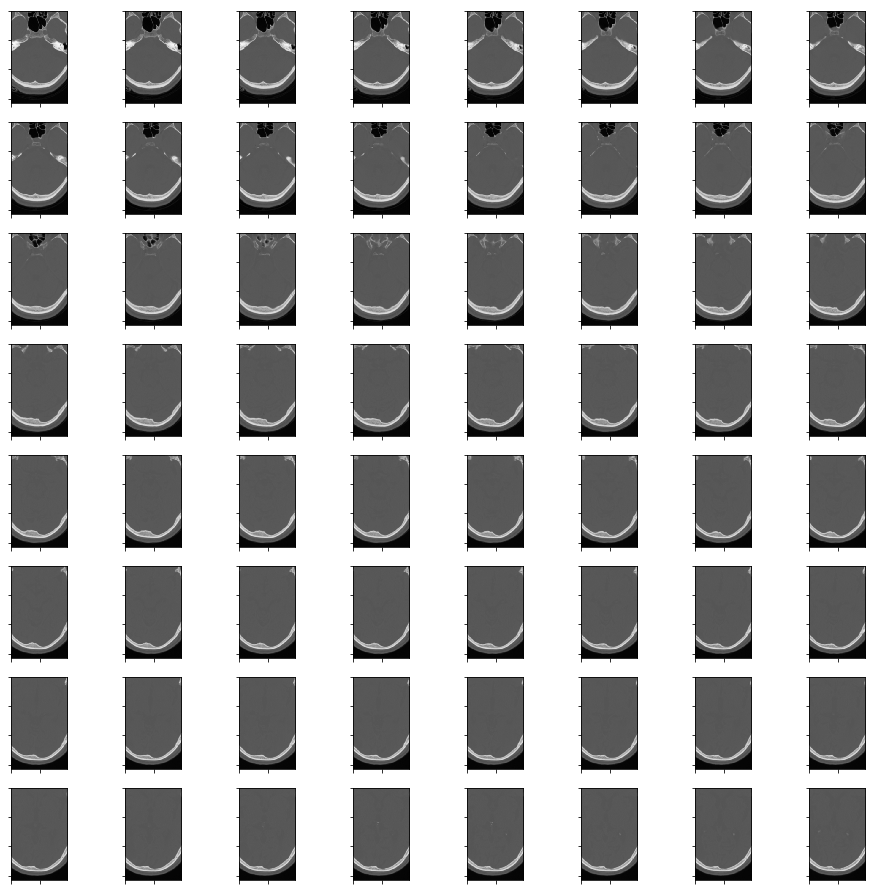

In [192]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-212', [ _get_tmap('crop_thin_316')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [ ]:
def thin_slice_from_hd5(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] > 100:
            random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
            random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
            random_slices = np.clip(random_slices, 3000, 10000)
            return random_slices
    raise ValueError('No CT slices in HD5')
    
TMAPS['thin_slice_map16'] = TensorMap('thin_slice_map16', shape=(512, 512, 16), tensor_from_file=thin_slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map50'] = TensorMap('thin_slice_map50', shape=(512, 512, 50), tensor_from_file=thin_slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map200'] = TensorMap('thin_slice_map200', shape=(512, 512, 200), tensor_from_file=thin_slice_from_hd5, cacheable=False, normalization={'zero_mean_std1': True})

thin_slice_map50 has (512, 512, 50)
(512, 512, 50)


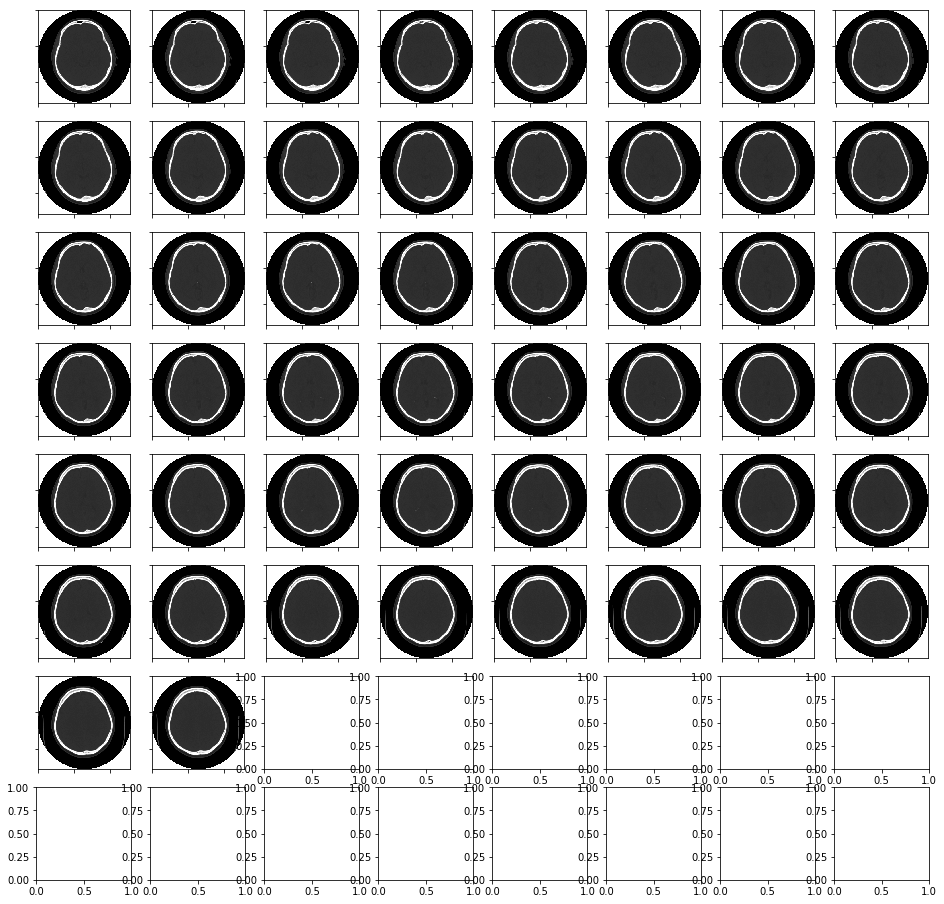

In [9]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-222', [ _get_tmap('thin_slice_map50')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])   

In [5]:
def slice_count(tm, hd5, dependents={}):
    for k in np.random.permutation(list(hd5.keys())):
        if any(exclude in k for exclude in EXCLUDE_SERIES):
            continue
        if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] < 50:
            random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
            random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
            dependents[tm.dependent_map] = np.sum(random_slices > 1000) / np.prod(random_slices.shape)
            return random_slices
    raise ValueError('No CT slices in HD5')

TMAPS['slice_map_count'] = TensorMap('slice_map_count', shape=(1,), cacheable=False)
TMAPS['slice_map_to_count'] = TensorMap('slice_map', shape=(512, 512, 1), dependent_map=TMAPS['slice_map_count'],
                                        tensor_from_file=slice_count, cacheable=False, 
                                        normalization={'zero_mean_std1': True})

In [3]:
TMAPS['r1_fracture'] = TensorMap('r1_fracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_fracture': 0, 'r1_fracture': 1})
TMAPS['r2_fracture'] = TensorMap('r2_fracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_fracture': 0, 'r2_fracture': 1})
TMAPS['r3_fracture'] = TensorMap('r3_fracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_fracture': 0, 'r3_fracture': 1})
TMAPS['r1_calvarialfracture'] = TensorMap('r1_calvarialfracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_calvarialfracture': 0, 'r1_calvarialfracture': 1})
TMAPS['r2_calvarialfracture'] = TensorMap('r2_calvarialfracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_calvarialfracture': 0, 'r2_calvarialfracture': 1})
TMAPS['r3_calvarialfracture'] = TensorMap('r3_calvarialfracture', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_calvarialfracture': 0, 'r3_calvarialfracture': 1})

In [4]:
TMAPS['r1_masseffect'] = TensorMap('r1_masseffect', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_masseffect': 0, 'r1_masseffect': 1})
TMAPS['r2_masseffect'] = TensorMap('r2_masseffect', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_masseffect': 0, 'r2_masseffect': 1})
TMAPS['r3_masseffect'] = TensorMap('r3_masseffect', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_masseffect': 0, 'r3_masseffect': 1})

In [5]:
TMAPS['r1_ich'] = TensorMap('r1_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_ich': 0, 'r1_ich': 1})
TMAPS['r2_ich'] = TensorMap('r2_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_ich': 0, 'r2_ich': 1})
TMAPS['r3_ich'] = TensorMap('r3_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_ich': 0, 'r3_ich': 1})

In [6]:
TMAPS['r1_iph'] = TensorMap('r1_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_iph': 0, 'r1_iph': 1})
TMAPS['r2_iph'] = TensorMap('r2_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_iph': 0, 'r2_iph': 1})
TMAPS['r3_iph'] = TensorMap('r3_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_iph': 0, 'r3_iph': 1})

In [7]:
TMAPS['r1_midlineshift'] = TensorMap('r1_midlineshift', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_midlineshift': 0, 'r1_midlineshift': 1})
TMAPS['r2_midlineshift'] = TensorMap('r2_midlineshift', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_midlineshift': 0, 'r2_midlineshift': 1})
TMAPS['r3_midlineshift'] = TensorMap('r3_midlineshift', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_midlineshift': 0, 'r3_midlineshift': 1})

In [8]:
TMAPS['r1_sah'] = TensorMap('r1_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_sah': 0, 'r1_sah': 1})
TMAPS['r2_sah'] = TensorMap('r2_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_sah': 0, 'r2_sah': 1})
TMAPS['r3_sah'] = TensorMap('r3_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_sah': 0, 'r3_sah': 1})

In [9]:
TMAPS['r1_sdh'] = TensorMap('r1_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_sdh': 0, 'r1_sdh': 1})
TMAPS['r2_sdh'] = TensorMap('r2_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_sdh': 0, 'r2_sdh': 1})
TMAPS['r3_sdh'] = TensorMap('r3_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_sdh': 0, 'r3_sdh': 1})

In [10]:
TMAPS['r1_chronicbleed'] = TensorMap('r1_chronicbleed', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_chronicbleed': 0, 'r1_chronicbleed': 1})
TMAPS['r2_chronicbleed'] = TensorMap('r2_chronicbleed', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_chronicbleed': 0, 'r2_chronicbleed': 1})
TMAPS['r3_chronicbleed'] = TensorMap('r3_chronicbleed', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_chronicbleed': 0, 'r3_chronicbleed': 1})

# The Model Factory
The function ***make_multimodal_multitask_model()*** takes lists of TensorMaps and connects them with intelligent goo.
### Model Architectures
- Classification
- Regression
- Multitask
- Multimodal
- Multimodal Multitask
- Autoencoders

## Binary Classification of CT Slice Command Line & Architecture
Jupyter is great, but can complicate productionizing code. We try to mitigate this by interacting with the jupyter notebook as if it were a command line call to one of ML4CVD's modes. 

In [26]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map',
            '--output_tensors', 'r1_masseffect',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_model.png')

2020-02-26 14:55:05,600 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_14-55_0.log.
2020-02-26 14:55:05,601 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors slice_map --output_tensors r1_midlineshift --num_workers 0



2020-02-26 14:55:05,602 - arguments:207 - INFO - Total TensorMaps:427 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=437500000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, conv_layers=[32], con

2020-02-26 14:55:06,092 - models:1198 - INFO - Saving architecture diagram to:./my_first_model.png
Epoch 1/1
2020-02-26 14:55:08,858 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 14:55:08,859 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 14:55:08,862 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.092 GB.
2020-02-26 14:55:08,865 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.373 GB.
2020-02-26 14:55:13,978 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 54
	Generator looped & shuffled over 88 paths.
	35 tensors were presented.
	The cache holds 34 out of a possible 176 tensors and is 39% full.
	So far there have been 1 cache hits.
	0 paths were skipped because they previously failed.
	5.12 seconds elapsed.
1/1 [==============================] - 10s 10s/step - loss: 0.6771 - ca

![My First Model Architecture](./my_firt_model.png)

In [7]:
sys.argv = ['test_scalar', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map_to_count',
            '--output_tensors', 'slice_map_count',
            '--id', 'slice_map_to_count',
            '--model_file', f'{MODEL_FOLDER}/slice_map_to_count/slice_map_to_count.hd5',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '12', 
            '--test_ratio', '0.6', 
            '--test_modulo', '0', 
            '--batch_size', '4',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
#_inspect_model(model, generate_train, generate_valid, 1, 1, True, './slice_map_to_count.png')
test_multimodal_multitask(args)

2020-02-26 23:07:06,928 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/slice_map_to_count/log_2020-02-26_23-07_0.log.
2020-02-26 23:07:06,930 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh test_scalar --tensors /home/sam/ct_brains/ --input_tensors slice_map_to_count --output_tensors slice_map_count --id slice_map_to_count --model_file ./recipes_output/slice_map_to_count/slice_map_to_count.hd5 --epochs 18 --training_steps 48 --validation_steps 22 --valid_ratio 0.3 --test_steps 12 --test_ratio 0.6 --test_modulo 0 --batch_size 4 --cache_size 0 --num_workers 0



2020-02-26 23:07:06,931 - arguments:207 - INFO - Total TensorMaps:402 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=4, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquer

2020-02-26 23:07:13,064 - tensor_generators:428 - INFO - Found 49 train, 163 validation, and 280 testing tensors at: /home/sam/ct_brains/
2020-02-26 23:07:13,099 - models:748 - INFO - Attempting to load model file from: ./recipes_output/slice_map_to_count/slice_map_to_count.hd5
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_slice_map_continuous (Inp (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 512, 512, 32) 320         input_slice_map_continuous[0][0] 
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 512, 512, 32) 0           conv2d_51[0][0]                  
___________

2020-02-26 23:07:19,871 - tensor_generators:110 - INFO - Starting test_worker_0.
2020-02-26 23:07:19,877 - tensor_generators:234 - INFO - test_worker_0 initialized cache of size 0.000 GB.
2020-02-26 23:07:20,116 - tensor_generators:363 - INFO - big_batch_from_minibatch 8.33% done.
2020-02-26 23:07:20,389 - tensor_generators:363 - INFO - big_batch_from_minibatch 16.67% done.
2020-02-26 23:07:20,679 - tensor_generators:363 - INFO - big_batch_from_minibatch 25.00% done.
2020-02-26 23:07:20,855 - tensor_generators:363 - INFO - big_batch_from_minibatch 33.33% done.
2020-02-26 23:07:21,144 - tensor_generators:363 - INFO - big_batch_from_minibatch 41.67% done.
2020-02-26 23:07:21,308 - tensor_generators:363 - INFO - big_batch_from_minibatch 50.00% done.
2020-02-26 23:07:21,494 - tensor_generators:363 - INFO - big_batch_from_minibatch 58.33% done.
2020-02-26 23:07:21,705 - tensor_generators:363 - INFO - big_batch_from_minibatch 66.67% done.
2020-02-26 23:07:21,914 - tensor_generators:363 - INF

{'slice_map_count_pearson': 0.9402197327214336}

<Figure size 576x1152 with 0 Axes>

<Figure size 3456x2304 with 0 Axes>

## Multitask Architecture

In [27]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map',
            '--output_tensors', 'r1_midlineshift', 'r2_midlineshift', 'r3_midlineshift',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multitask_model.png')

2020-02-26 14:55:20,878 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_14-55_0.log.
2020-02-26 14:55:20,880 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors slice_map --output_tensors r1_midlineshift r2_midlineshift r3_midlineshift --num_workers 0



2020-02-26 14:55:20,882 - arguments:207 - INFO - Total TensorMaps:427 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=437500000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dr

2020-02-26 14:55:22,888 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 3:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 44
		[ValueError: Not a location (invalid object ID)] - 10
		[ValueError: Not a dataset (not a dataset)] - 1
	Generator looped & shuffled over 88 paths.
	33 tensors were presented.
	The cache holds 34 out of a possible 176 tensors and is 39% full.
	So far there have been 67 cache hits.
	0 paths were skipped because they previously failed.
	3.68 seconds elapsed.
2020-02-26 14:55:24,104 - models:1198 - INFO - Saving architecture diagram to:./my_first_multitask_model.png
Epoch 1/1
2020-02-26 14:55:27,594 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 14:55:27,595 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 14:55:27,597 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.090 GB.
2020-02-26 14:55:27,598 - tensor_generators:234 - INFO - train

![multitask](./my_first_multitask_model.png)

## Multimodal Architecture

In [28]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map', 'thin_slice_map16',
            '--output_tensors', 'r1_midlineshift',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multimodal_model.png')

2020-02-26 14:55:41,372 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_14-55_0.log.
2020-02-26 14:55:41,374 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors slice_map thin_slice_map16 --output_tensors r1_midlineshift --num_workers 0



2020-02-26 14:55:41,376 - arguments:207 - INFO - Total TensorMaps:427 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=437500000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, conv

2020-02-26 14:55:42,579 - models:1198 - INFO - Saving architecture diagram to:./my_first_multimodal_model.png
Epoch 1/1
2020-02-26 14:55:46,752 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 14:55:46,753 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 14:55:46,755 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.428 GB.
2020-02-26 14:55:46,764 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.428 GB.
2020-02-26 14:56:08,715 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 59
	Generator looped & shuffled over 87 paths.
	29 tensors were presented.
	The cache holds 24 out of a possible 261 tensors and is 100% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	21.96 seconds elapsed.
1/1 [==============================] - 23s 23s/step - loss

![Multimodal](./my_first_multimodal_model.png)

## CT Slice AutoEncoder

In [50]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'crop_thin_64',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_ct_slice_autoencoder.png')

2020-02-26 23:38:23,538 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_23-38_0.log.
2020-02-26 23:38:23,539 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brain/ --input_tensors crop_thin_64 --output_tensors crop_thin_64 --num_workers 0



2020-02-26 23:38:23,540 - arguments:207 - INFO - Total TensorMaps:446 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=437500000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, conv_layers=[32], conv

2020-02-26 23:38:24,162 - models:1198 - INFO - Saving architecture diagram to:./my_ct_slice_autoencoder.png
Epoch 1/1
2020-02-26 23:38:27,078 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 23:38:27,079 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 23:38:27,082 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.008 GB.
2020-02-26 23:38:27,082 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.008 GB.
2020-02-26 23:38:27,090 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 5
	Generator looped & shuffled over 4 paths.
	0 tensors were presented.
	The cache holds 0 out of a possible 8 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	0.01 seconds elapsed.
2020-02-26 23:38:27,092 - tensor_generators:301 - INFO - Worker valid

ValueError: Completed an epoch but did not find any tensors to yield

![ct auto encoder](./my_ct_slice_autoencoder.png)

# U Net

In [210]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'middle_slices_16',
            '--output_tensors', 'middle_slices_16',
            '--u_connect',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_ct_slice_unet_autoencoder.png')

2020-02-26 22:06:19,263 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/no_id/log_2020-02-26_22-06_0.log.
2020-02-26 22:06:19,265 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors middle_slices_16 --output_tensors middle_slices_16 --u_connect --num_workers 0



2020-02-26 22:06:19,266 - arguments:207 - INFO - Total TensorMaps:6362 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=437500000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuous_file_normalize=False, conv_dilate=False, conv_dropout=0.0, 

2020-02-26 22:06:19,916 - models:1198 - INFO - Saving architecture diagram to:./my_ct_slice_unet_autoencoder.png
Epoch 1/1
2020-02-26 22:06:23,173 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 22:06:23,175 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 22:06:23,186 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.436 GB.
2020-02-26 22:06:23,187 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.436 GB.


KeyboardInterrupt: 

![unet](./my_ct_slice_unet_autoencoder.png)

## Overfit:

In [195]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'middle_slices_16',
            '--output_tensors', 'r1_calvarialfracture', 'r1_masseffect',
            '--output_folder', MODEL_FOLDER,
            '--dense_blocks', '32', '24',
            '--pool_x', '4',
            '--pool_y', '4',
            '--id', 'middle_slices_16_r1_calvarialfracture_mass_effect',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '2', 
            '--test_ratio', '0.1', 
            '--test_modulo', '0', 
            '--batch_size', '6',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-02-26 21:48:55,971 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/middle_slices_16_r1_calvarialfracture_mass_effect/log_2020-02-26_21-48_0.log.
2020-02-26 21:48:55,974 - arguments:206 - INFO - Command Line was:

./scripts/tf.sh train --tensors /home/sam/ct_brains/ --input_tensors middle_slices_16 --output_tensors r1_calvarialfracture r1_masseffect --dense_blocks 32 24 --pool_x 4 --pool_y 4 --id middle_slices_16_r1_calvarialfracture_mass_effect --epochs 18 --training_steps 48 --validation_steps 22 --valid_ratio 0.3 --test_steps 2 --test_ratio 0.1 --test_modulo 0 --batch_size 6 --cache_size 0 --num_workers 0



2020-02-26 21:48:55,976 - arguments:207 - INFO - Total TensorMaps:6359 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquer

Epoch 1/18
2020-02-26 21:48:58,186 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-26 21:48:58,187 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-26 21:48:58,189 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.000 GB.
2020-02-26 21:48:58,190 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.000 GB.
2020-02-26 21:49:12,775 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		[ValueError: No CT slices in HD5] - 94
		[skipped_paths] - 2
	Generator looped & shuffled over 151 paths.
	56 tensors were presented.
	The cache holds 0 out of a possible 453 tensors and is nan% full.
	So far there have been 0 cache hits.
	2 paths were skipped because they previously failed.
	14.59 seconds elapsed.
19/48 [==========>...................] - ETA: 38s - loss: 1.4530 - output_r1_calvarialfracture_categorical_loss: 0.7540 - output_r1_masseffect_ca

28/48 [================>.............] - ETA: 9s - loss: 0.9588 - output_r1_calvarialfracture_categorical_loss: 0.3820 - output_r1_masseffect_categorical_loss: 0.5767 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8750 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8750 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.7202 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.7202 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.0000e+00 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 1.0000 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.0000e+002020-02-26 21:50:33,180 - tensor_generators:301 - INFO - Worker train_worker_0 - In true ep

37/48 [======================>.......] - ETA: 7s - loss: 0.9787 - output_r1_calvarialfracture_categorical_loss: 0.4892 - output_r1_masseffect_categorical_loss: 0.4895 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8243 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8243 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.7793 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.7955 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.3378 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9662 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.27032020-02-26 21:51:29,453 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 7:
	

47/48 [============================>.] - ETA: 0s - loss: 0.8364 - output_r1_calvarialfracture_categorical_loss: 0.3257 - output_r1_masseffect_categorical_loss: 0.5107 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8723 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8723 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.7482 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.7688 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.3333 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9199 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.21992020-02-26 21:52:25,401 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 10:


47/48 [============================>.] - ETA: 0s - loss: 0.7638 - output_r1_calvarialfracture_categorical_loss: 0.3157 - output_r1_masseffect_categorical_loss: 0.4480 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8936 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8936 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0426 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0426 - output_r1_masseffect_categorical_categorical_accuracy: 0.8156 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.8362 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.4468 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9507 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.36882020-02-26 21:53:21,392 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 11:
	Th

48/48 [==============================] - 50s 1s/step - loss: 0.6827 - output_r1_calvarialfracture_categorical_loss: 0.2624 - output_r1_masseffect_categorical_loss: 0.4203 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.8958 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.8924 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.1875 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.1354 - output_r1_masseffect_categorical_categorical_accuracy: 0.8299 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.8451 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.4965 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 0.9500 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.4649 - val_loss: 1.7548 - val_output_r1_calvarialfracture_categorical_loss: 0.8790 - val_output_r1_masseffe


Epoch 00007: val_loss did not improve from 1.22480
Epoch 8/18
15/48 [========>.....................] - ETA: 13s - loss: 0.3332 - output_r1_calvarialfracture_categorical_loss: 0.0569 - output_r1_masseffect_categorical_loss: 0.2762 - output_r1_calvarialfracture_categorical_categorical_accuracy: 0.9889 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_precision: 0.9889 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_precision: 0.0000e+00 - output_r1_calvarialfracture_categorical_no_r1_calvarialfracture_recall: 1.0000 - output_r1_calvarialfracture_categorical_r1_calvarialfracture_recall: 0.0000e+00 - output_r1_masseffect_categorical_categorical_accuracy: 0.9222 - output_r1_masseffect_categorical_no_r1_masseffect_precision: 0.8856 - output_r1_masseffect_categorical_r1_masseffect_precision: 0.9333 - output_r1_masseffect_categorical_no_r1_masseffect_recall: 1.0000 - output_r1_masseffect_categorical_r1_masseffect_recall: 0.74442020-02-26 21:55:16,816 - tensor_ge

KeyboardInterrupt: 

The Erowid Data Scrape.

In [ ]:
http://human.brain-map.org/mri_viewers/data